In [1]:
from utils import u_time as ut
from utils import u_arrays as ua
from eod import read_eod as re
import salem
import numpy as np
from scipy.ndimage.measurements import label 
import pyproj
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from scipy.interpolate import griddata
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
from wavelet import util
import cleo
import pickle as pkl
import os
from scipy import ndimage
from skimage.feature import match_template
from skimage.measure import compare_ssim
import xarray as xr
from netCDF4 import Dataset

pylab.rcParams['figure.figsize'] = 20., 12.
%matplotlib inline

In [238]:
dd = {'y' : [], 'm' : [], 'perc' : [], 'max' : [], 'p' : []}
files = ua.locate(".nc", '/users/global/cornkle/MCSfiles/WA30')
for f in files:
    
    dic = xr.open_dataset(f)
    tmask=dic['tmask'].values.copy()    
    p=dic['p'].values.copy()
    
    pp=p[np.where(tmask==1)]
    perc=np.percentile(pp[np.isfinite(pp)], 99)
    maxi=np.max(pp[np.isfinite(pp)])
    #print(dic['time.year'].values)
    dd['y'].append(dic['time.year'].values)
    dd['m'].append(dic['time.month'].values)
    dd['perc'].append(perc)
    dd['max'].append(maxi)
    dd['p'].append(pp[np.isfinite(pp)])    

In [239]:
f = files[0]
di = xr.open_dataset(f)
di.keys()

KeysView(<xarray.Dataset>
Dimensions:  (x: 155, y: 255)
Coordinates:
    lon      (x, y) float64 -10.89 -10.85 -10.8 -10.76 -10.71 -10.67 -10.62 ...
    lat      (x, y) float64 9.262 9.262 9.262 9.262 9.262 9.262 9.262 9.262 ...
    time     datetime64[ns] 2004-06-02T03:17:00
  * x        (x) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * y        (y) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
Data variables:
    tc_lag2  (x, y) float64 nan nan nan nan nan nan nan nan nan nan nan nan ...
    tmask    (x, y) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
    tc_lag0  (x, y) float64 nan nan nan nan nan nan nan nan nan nan nan nan ...
    t_lag2   (x, y) float64 nan nan nan nan nan nan nan nan nan nan nan nan ...
    pmask    (x, y) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
    p        (x, y) float64 nan nan nan nan nan nan nan nan nan nan nan nan ...
    t_lag0   (x, y) float64 nan nan nan nan nan nan nan nan nan nan

<function matplotlib.pyplot.colorbar>

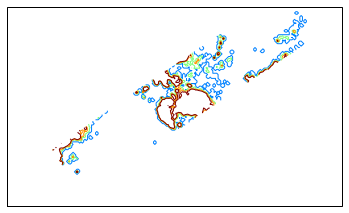

In [240]:

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

#plt.contourf(di.lon, di.lat, di.p, levels=np.arange(0,20, 0.1), transform=ccrs.PlateCarree())
plt.contour(di.lon, di.lat, di.p , levels=np.arange(-0.5,2, 0.5), transform=ccrs.PlateCarree(), )
plt.colorbar

In [201]:
perc=[]
for y in range(2004,2015):
   # for m in range(8,10):
        ok = np.where((np.array(dd['y'])==y) & ((np.array(dd['m'])==9) ))#^ (np.array(dd['m'])==9)) )
        #print(ok[0].size)
        mmean=np.mean(np.array(dd['perc'])[ok])
        perc.append(mmean)

In [203]:
perc=[]
for y in range(2004,2015):
    #for m in range(9,10):
        ok = np.where((np.array(dd['y'])==y) & ((np.array(dd['m'])==9) ))
        dlist=[]
        for a in np.array(dd['p'])[ok]:
            dlist.extend(a)
        mmean=np.percentile(np.array(dlist), 99)
        perc.append(mmean)        

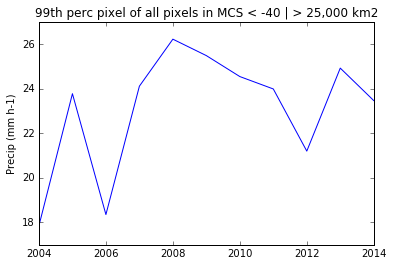

In [217]:
xtick=list(range(2004,2015,2))

fig, ax = plt.subplots()
plt.plot(perc)
ax.set_xticklabels(xtick)
ax.set_ylabel('Precip (mm h-1)')
ax.set_title('99th perc pixel of all pixels in MCS < -40 | > 25,000 km2')

plt.savefig('/users/global/cornkle/C_paper/figs/TRMM_MCS_trend.jpg')

In [136]:
perc=[]
for y in range(2004,2015):
        ok = np.where((np.array(dd['y'])==y))
        mmean=np.max(np.array(dd['perc'])[ok])
        perc.append(mmean)

In [139]:
perc=[]
for y in range(2004,2015):
   
        ok = np.where((np.array(dd['y'])==y))
        dlist=[]
        for a in np.array(dd['p'])[ok]:
            dlist.extend(a)
        mmean=np.percentile(np.array(dlist), 99)
        perc.append(mmean)

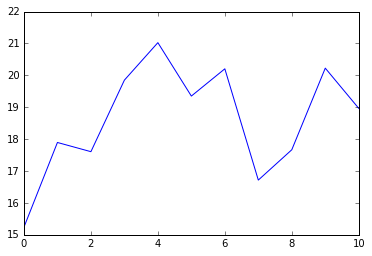

In [144]:
plt.plot(perc)

In [62]:
files = ua.locate(".nc", '/users/global/cornkle/MCSfiles/WA30')
dic = xr.open_dataset(files[0])
dic['time.year'].values

array(2004)

In [43]:
tmask=dic['tmask'].values.copy()
pmask=dic['pmask'].values.copy()
t=dic['t_lag0'].values.copy()
p=dic['p'].values.copy()



In [44]:
t[np.where(tmask==0)]=np.nan
p[np.where(tmask==0)]=np.nan

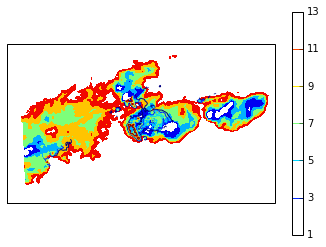

In [46]:
ax = plt.axes(projection=ccrs.PlateCarree())
plt.contourf(dic['lon'], dic['lat'], t, levels=np.arange(-70,-40,5), transform=ccrs.PlateCarree(), cmap='jet')
plt.contour(dic['lon'], dic['lat'], p, levels=np.arange(1,15,2), transform=ccrs.PlateCarree())

ax.coastlines()
cbar=plt.colorbar()

In [52]:
pp=p[np.where(tmask==1)]
np.percentile(pp[np.isfinite(pp)], 99)

15.748211580482218

In [81]:
outt=np.array(dic['tc_lag3'].values.copy())
                        
outt[np.isnan(outt)]=150
outt[outt>-40]=150
grad=np.gradient(outt)
outt[outt>-40]=-55
o2=outt.copy()
nok = np.where(abs(grad[0]) > 80)
d=2
i=nok[0]
j=nok[1]    
        
for ii,jj in zip(i,j):    
    kernel=o2[ii-d:ii+d+1, jj-d:jj+d+1]
              #  if not kernel.any():
                 #   continue
         #   else:    
    o2[ii-d:ii+d+1, jj-d:jj+d+1]=ndimage.gaussian_filter(kernel, 3, mode='nearest')
print(outp.shape)
print(o2.shape)
wav = util.waveletTP_localMax(o2, outp, 5) 
print(wav['p'].shape)
print(wav['t'].shape)
o2[np.where(dic['pmask'].values==0)]=np.nan   

z = wav['z'] 
y = wav['y']  
x = wav['x']

(56, 55)
(56, 55)
(46, 56, 55)
(46, 56, 55)


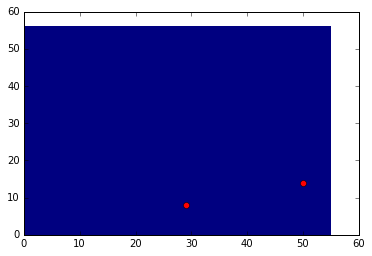

In [82]:
o2[np.isnan(o2)]=0
plt.pcolormesh(dic['tc_lag3'])
plt.plot(x,y,'ro')

In [85]:
i=1
zz=z[i]
xx=x[i]
yy=y[i]
iscale = (np.ceil(wav['scales'][zz]/2./5.)).astype(int)
                
tw = wav['t'][zz, :, :].copy()
pw = wav['p'][zz, :, :].copy()   #copy??
                
#tw[np.isnan(tw)]=0
#pw[np.isnan(pw)]=0
tw[np.where(dic['pmask'].values==0)]=np.nan            
pw[np.where(dic['pmask'].values==0)]=np.nan     
 
twmax=tw[yy,xx]   

#Find all indices within the local circle of radius iscale...
# ... Then average over those indices
xloc1 = np.arange(xx-iscale,xx+iscale+1)
yloc1 = np.arange(yy-iscale,yy+iscale+1)
xloc,yloc = np.meshgrid(xloc1,yloc1)
distloc = ( (xloc-xx)**2 + (yloc-yy)**2 ) ** .5
#
indloc = (distloc <= iscale).nonzero()
ycirc = indloc[0] - iscale + yy
xcirc = indloc[1] - iscale + xx 

In [88]:
 noky=np.where(ycirc==pw.shape[0])   # if the circle is off the edge                               
if noky[0].size>0:
    ycirc=np.delete(ycirc,noky)
    xcirc=np.delete(xcirc,noky)
#                    
nokx=np.where(xcirc==pw.shape[1])                                  
if nokx[0].size>0:
    ycirc=np.delete(ycirc,nokx)
    xcirc=np.delete(xcirc,nokx)  

In [89]:
xcirc

array([50, 47, 48, 49, 50, 51, 52, 53, 46, 47, 48, 49, 50, 51, 52, 53, 54,
       46, 47, 48, 49, 50, 51, 52, 53, 54, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 46, 47, 48, 49, 50, 51, 52, 53, 54, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 47, 48, 49, 50, 51, 52, 53, 50])

In [27]:
outt=dic['tc_lag0'].values.copy()
mmeans=np.percentile(outt[np.isfinite(outt)], 30)
print(mmeans)
maxi=np.nanmin(outt)
thresh=maxi+15
print(thresh)

-68.0
-71.5670240739


In [28]:
outp=dic['p'].values.copy()
outp[np.isnan(outp)]=-10**-5
outt[np.isnan(outt)]=150 
outt[outt>-40]=150
grad=np.gradient(outt)

outt[outt>-40]=-60#-40#-150
mmeans=dic.meanT_cut

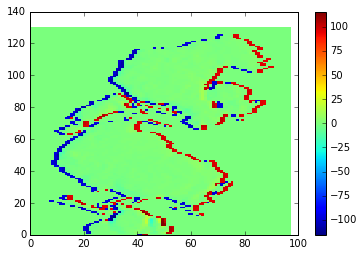

In [29]:

plt.pcolormesh(grad[1])
plt.colorbar()

nok = np.where(abs(grad[0]) > 80)

In [30]:
o2=outt.copy()
#o1=outt.copy()
#o2[o2<-100]=mmeans
d=2
i=nok[0]
j=nok[1]

In [33]:
for ii,jj in zip(i,j):
    
    kernel=o2[ii-d:ii+d+1, jj-d:jj+d+1]
    if not kernel.any():
        continue
    else:    
        o2[ii-d:ii+d+1, jj-d:jj+d+1]=ndimage.gaussian_filter(kernel, 3, mode='nearest')

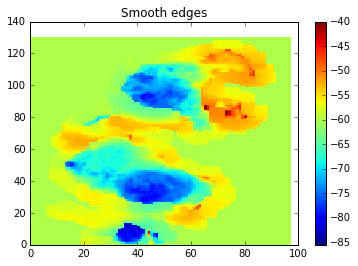

In [34]:
plt.pcolormesh(o2)
plt.colorbar()
plt.title('Smooth edges')

In [35]:
pos=3

wav = util.waveletTP_localMax(o2, outp, 5)
print(wav['scales'][pos])
tt=wav['t'][pos,:,:]
pp=wav['p'][pos,:, :]
#tt[np.where(dic['pmask'].values==0)]=0
#pm=pp.max()
#tm=tt.max()
#tt=tt/tm
#pp=pp/pm
#tt[tt>0.1]=1
#pp[pp>0.1]=1
#tt[tt<=0.1]=0
#pp[pp<=0.1]=0
wav['x']

12.0


array([46, 41, 36, 15, 37, 47, 48])

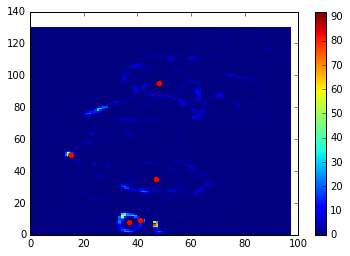

In [26]:
plt.pcolormesh(tt, )
plt.colorbar()
plt.plot(wav['x'],wav['y'], 'ro')

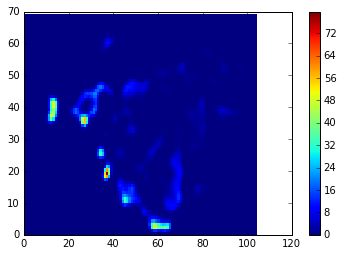

In [156]:
plt.pcolormesh(tt, )
plt.colorbar()
tp=tt.copy()
tp[tp<10]=0

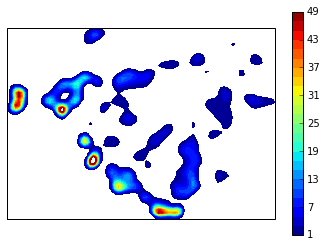

In [157]:
ax = plt.axes(projection=ccrs.PlateCarree())
#plt.contourf(dic['lon'], dic['lat'], o2, levels=np.arange(-80,-40,1), transform=ccrs.PlateCarree(), cmap='jet')
plt.contourf(dic['lon'], dic['lat'], tt, levels=np.arange(1,50,2), transform=ccrs.PlateCarree())
#plt.contourf(dic['lon'], dic['lat'], outp, levels=np.arange(0,10,1), transform=ccrs.PlateCarree())
ax.coastlines()
cbar=plt.colorbar()

In [75]:
thing=match_template(tt, pp[5:-5, 5:-5])
print(max(thing.flatten()))
y,x = np.unravel_index(np.argmax(thing), thing.shape)
print(y, x)
print(y-5, x-5)

0.145965
1 0
-4 -5


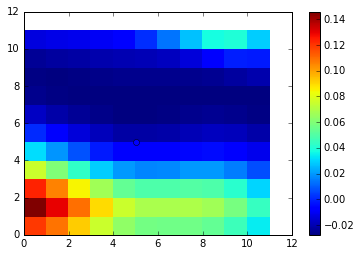

In [76]:
plt.pcolormesh(thing)
plt.colorbar()
plt.plot(5,5, 'bo')

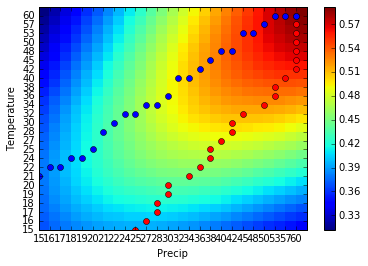

In [73]:
plt.pcolormesh(nl_resh)#, levels=np.arange(0.25,0.7,0.01))
plt.xticks(rise, arr)
plt.yticks(rise, arr)
plt.colorbar()
plt.plot(x,rise, 'ro') # x, y convention cause numpy is stupid and confusing
plt.plot(rise,y, 'bo')
plt.ylabel('Temperature')
plt.xlabel('Precip')
plt.savefig('/users/global/cornkle/MCSfiles/save/TP_scales.pdf')

In [57]:
wave = pkl.load( open ('/users/global/cornkle/MCSfiles/save/MCScorr_scales_allyears.p', 'rb'))
       
arr=np.array([15,   16,   17,   18,   19,   20,   21,   22,   24,
         25,   27,   28,   30,   32,   34,   36,   38,   40,
         42,   45,   48,   50,   53,   57,   60], dtype=str)
l=[]
for k in arr:
    for kk in arr:
        l.append(np.mean(wave[k][kk]['corr']))         
                
nl=np.array(l)
nl_resh=nl.reshape(25,25)
y = np.argmax(nl_resh, axis=0)  #temperature for P, index for getting the right T if you decide on a size for P
x = np.argmax(nl_resh, axis=1) # precipitation for T, index for getting the right P if you decide on a size for T
rise=range(25)
     
PforT=arr[np.array(x)] # p for T
TforP=arr[np.array(y)] # T for p 
PforT=PforT.astype(np.str)
TforP=TforP.astype(np.str)
    
non = lambda s: s if s<0 else None
mom = lambda s: max(0,s)

dic={'p': [], 't' : []}

In [47]:
tpos=arr[12]      # use 12
ppos=PforT[12]
tt=wave[tpos][ppos]['twavelet']
pp=wave[tpos][ppos]['pwavelet']
porig=wave[tpos][ppos]['porig']
torig=wave[tpos][ppos]['torig']
xx=wave[tpos][ppos]['x']
yy=wave[tpos][ppos]['y']

In [50]:
pos=15       # use 10
t=tt[pos] 
p=pp[pos]
po=porig[pos]
to=torig[pos]
x=xx[pos] 
y=yy[pos] 
                                    
ox, oy = x-5, y-5

shift_p = np.zeros_like(p)
shift_p[mom(oy):non(oy), mom(ox):non(ox)] = p[mom(-oy):non(-oy), mom(-ox):non(-ox)]    
            
shift_po = np.zeros_like(po)
shift_po[mom(oy):non(oy), mom(ox):non(ox)] = po[mom(-oy):non(-oy), mom(-ox):non(-ox)]                  
ok = np.where(shift_p > 1)
            
pout=shift_po[ok]
tout=t[ok]

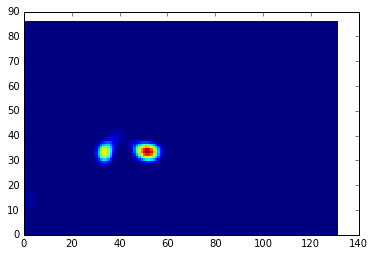

In [51]:
plt.pcolormesh(shift_p)

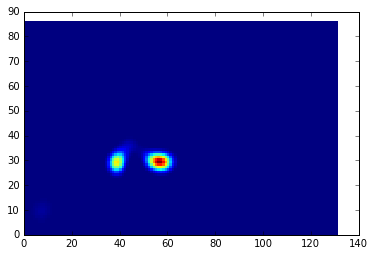

In [52]:
plt.pcolormesh(p)

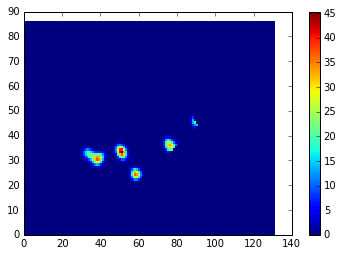

In [53]:
plt.pcolormesh(t)
plt.colorbar()

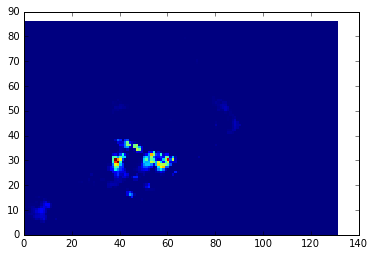

In [54]:
plt.pcolormesh(po)

In [214]:
arr=np.array([15,   16,   17,   18,   19,   20,   21,   22,   24,
         25,   27,   28,   30,   32,   34,   36,   38,   40,
         42,   45,   48,   50,   53,   57,   60], dtype=str)
         
ext=np.array([20,30,40], dtype=str)      
rrange=list(range(arr.size))
scales=np.in1d(arr, ext)
rpos=np.array(rrange)[scales]
arr[rpos]

array(['20', '30', '40'], 
      dtype='<U2')

In [3]:
wavelet = pkl.load( open ('/users/global/cornkle/MCSfiles/save/MCS_wavelet_allyears_perc.p', 'rb'))

In [4]:
wavelet.keys()

dict_keys(['porig', '40', 'porig_max', 'torig1', '20', '30', 'torig2', 'torig2_min', 'torig1_min'])

In [14]:
np.percentile(wavelet['torig1'][0], 99)
#wavelet['torig1'][0].min()

-38.74573167770118

In [266]:
len(wavelet['30']['twavelet1_max'])
len(wavelet['30']['pwavelet_max'])

392

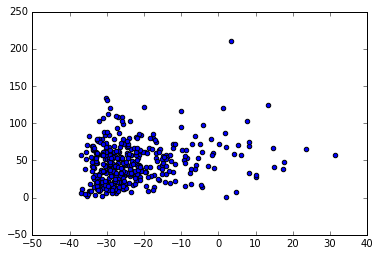

In [268]:
plt.scatter(wavelet['torig1_max'],wavelet['porig_max'] )

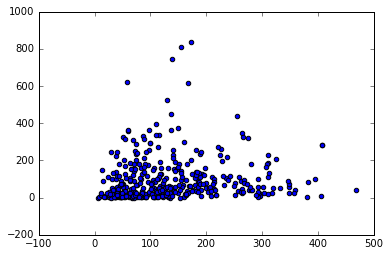

In [260]:
plt.scatter(wavelet['40']['twavelet1_max'],wavelet['40']['pwavelet_max'] )

In [38]:
wavelet['torig1'][0].min()
wavelet['torig1_min'][0]

-89.937429909100288

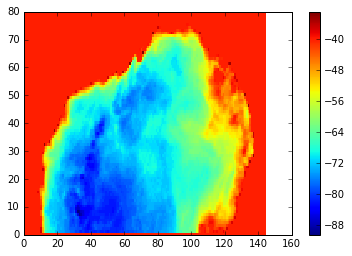

In [18]:
plt.pcolormesh(wavelet['torig1'][3])
plt.colorbar()

In [258]:
print(wavelet['30']['pwavelet_max'][60])

399.305214195
